<a href="https://colab.research.google.com/github/RajashreeDahal4/SUNRGBD-Segmentation/blob/main/Resnet18_skip_multiplygate3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jul  1 14:39:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow==2.4.1
import tensorflow
print(tensorflow.__version__)

     |████████████████████████████████| 394.3MB 46kB/s 
     |████████████████████████████████| 471kB 42.2MB/s 
     |████████████████████████████████| 2.9MB 9.6MB/s 
     |████████████████████████████████| 3.8MB 40.1MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
2.4.1


In [3]:
! pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-44j51tj2
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-44j51tj2
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp37-none-any.whl size=20049 sha256=e2de9aca45bf211ba2b24af30c471a14867c5501203d0f91a7f70381f669a801
  Stored in directory: /tmp/pip-ephem-wheel-cache-ecj3q3eh/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [4]:
# model.summary()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt 
import numpy as np 
import h5py
import cv2 as cv 
from PIL import Image, ImageDraw
import json 
import os 
import glob 
import re 
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate,MaxPooling2D, AveragePooling2D,Input, BatchNormalization, Activation, UpSampling2D, Concatenate, LeakyReLU,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Multiply,SpatialDropout2D,Add, Reshape,Softmax
from tensorflow.keras.optimizers import Adam 
#using tensorflow backend 16 so keras backend still 32bytes so no keras to be used
# from keras.layers.merge import concatenate,Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc
import psutil
from tensorflow.keras.layers import Lambda


In [6]:
# for tensorflow.keras
from classification_models.tfkeras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')
model = ResNet18((480, 640, 3), weights='imagenet')

46981120/46977688 [==============================] - 1s 0us/step


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 480, 640, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 486, 646, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 240, 320, 64) 9408        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [8]:
layer = model.get_layer
print(layer)

<bound method Model.get_layer of <tensorflow.python.keras.engine.functional.Functional object at 0x7f8d10090f10>>


In [9]:
# tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
# # tf.compat.v1.disable_eager_execution()

In [10]:
category = """wall, floor, cabinet, bed, chair, sofa, table, door, window, bookshelf, picture, counter, blinds, desk, shelves, curtain, dresser
, pillow, mirror, floor mat, clothes, ceiling, books, fridge, tv, paper, towel, shower curtain, box, whiteboard, person, nightstand, toilet, sink
, lamp, bathtub, bag"""
category = category.split(r', ')
category = [i.replace('\n','') for i in category]
category_1 = ['background']
for categ in category:category_1.append(categ) 
print(category_1)
category_dict = {k:category_1.index(k) for k in category_1}
print(category_dict)
reverse_map={i:k for k,i in category_dict.items()}
color_list=['gray','red','green','#FFFF00','#8c564b','#4B8BBE','#306998','#FFE873','#FFD43B','#646464','#5a0000','#003a27','#C0C0C0','#808080','#800000','#808000','#00FF00','#00FFFF','#008080','#000080','#FF00FF','#800080','#CD5C5C','#F08080','#FA8072','#E9967A','#FFA07A','#DC143C','#FF7F50','#FFD700','#ffffe0','#bdb76b','#228b22','#B0E0E6','#4169e1','#f0ffff','#d2691e','#BC8F8F']
class_color_map={k:color_list[i] for i,k in enumerate(reverse_map.keys())}

['background', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 'mirror', 'floor mat', 'clothes', 'ceiling', 'books', 'fridge', 'tv', 'paper', 'towel', 'shower curtain', 'box', 'whiteboard', 'person', 'nightstand', 'toilet', 'sink', 'lamp', 'bathtub', 'bag']
{'background': 0, 'wall': 1, 'floor': 2, 'cabinet': 3, 'bed': 4, 'chair': 5, 'sofa': 6, 'table': 7, 'door': 8, 'window': 9, 'bookshelf': 10, 'picture': 11, 'counter': 12, 'blinds': 13, 'desk': 14, 'shelves': 15, 'curtain': 16, 'dresser': 17, 'pillow': 18, 'mirror': 19, 'floor mat': 20, 'clothes': 21, 'ceiling': 22, 'books': 23, 'fridge': 24, 'tv': 25, 'paper': 26, 'towel': 27, 'shower curtain': 28, 'box': 29, 'whiteboard': 30, 'person': 31, 'nightstand': 32, 'toilet': 33, 'sink': 34, 'lamp': 35, 'bathtub': 36, 'bag': 37}


In [11]:
print(len(category_dict))

38


In [12]:

AUTO = tf.data.experimental.AUTOTUNE
Image_width = 640 
Image_height = 480 
no_classes = len(category_dict)
def load_data(path, split=0.2):
    images = sorted(glob.glob(os.path.join(path, "image/*")))
    print(len(images))
    masks = sorted(glob.glob(os.path.join(path, "mask2/*")))
    print(len(masks))
    total_size = 8033
    test_size = 2033
    valid_size=1000
    training_x, test_x = train_test_split(images[:8033], test_size=test_size, random_state=42)
    training_y, test_y = train_test_split(masks[:8033], test_size=test_size, random_state=42)
    train_x, valid_x = train_test_split(training_x, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(training_y, test_size=valid_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y),(test_x, test_y)
(train_x,train_y),(valid_x,valid_y),(test_x, test_y)=load_data('/content/drive/MyDrive/depth')
train_size=len(train_x)
valid_size=len(valid_x)

def read_image(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_NEAREST)
  
    x = to_categorical(x,num_classes=no_classes)
    x = x[:,:,:]
    # x = np.expand_dims(x, axis=-1)
    # x=np.concatenate([x,x],axis=-1)
    x=tf.cast(x,dtype=tf.float32)
    return x
# read_mask('/content/drive/MyDrive/depth/mask100/mask1.png')
def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float32,tf.float32])
    x.set_shape([Image_height, Image_width, 3])
    y.set_shape([Image_height, Image_width, no_classes])
    return x,y
    
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)
    # dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTO)
    return dataset
train_dataset=tf_dataset(train_x,train_y,batch=4)
valid_dataset=tf_dataset(valid_x,valid_y,batch=4)
valid_dataset

8033
8033


<PrefetchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 38)), types: (tf.float32, tf.float32)>

In [13]:
print(test_x[:100])

['/content/drive/MyDrive/depth/image/image7665.jpg', '/content/drive/MyDrive/depth/image/image4706.jpg', '/content/drive/MyDrive/depth/image/image3728.jpg', '/content/drive/MyDrive/depth/image/image4414.jpg', '/content/drive/MyDrive/depth/image/image1285.jpg', '/content/drive/MyDrive/depth/image/image5134.jpg', '/content/drive/MyDrive/depth/image/image4020.jpg', '/content/drive/MyDrive/depth/image/image894.jpg', '/content/drive/MyDrive/depth/image/image4555.jpg', '/content/drive/MyDrive/depth/image/image752.jpg', '/content/drive/MyDrive/depth/image/image4080.jpg', '/content/drive/MyDrive/depth/image/image6642.jpg', '/content/drive/MyDrive/depth/image/image7309.jpg', '/content/drive/MyDrive/depth/image/image947.jpg', '/content/drive/MyDrive/depth/image/image4784.jpg', '/content/drive/MyDrive/depth/image/image1939.jpg', '/content/drive/MyDrive/depth/image/image827.jpg', '/content/drive/MyDrive/depth/image/image5069.jpg', '/content/drive/MyDrive/depth/image/image4038.jpg', '/content/drive

In [14]:
import tensorflow as tf
classes=38
import math

In [15]:
def softmax1(x):
  return tf.exp(x) / tf.reduce_sum(tf.exp(x), axis=-1)

In [16]:
def function_for_entropy(xx):
  return -tf.reduce_sum(tf.math.multiply(xx,tf.experimental.numpy.log2(xx)),axis=3)

In [17]:
class Entropy(tf.keras.layers.Layer):
    def __init__(self):
      super(Entropy, self).__init__()
    def call(self,xx):
      # xx=tf.clip_by_value(xx,clip_value_min=0.00001,clip_value_max=10000)
      return -tf.reduce_sum(tf.math.multiply(xx,tf.experimental.numpy.log2(xx)),axis=3)

In [18]:
def res_18_encoder(inputs):
    skip_layers = []
    model2 = ResNet18(include_top=False,weights='imagenet',input_tensor=inputs)
    layer_names = ['conv0','stage1_unit2_conv2','stage2_unit2_conv2','stage3_unit2_conv2']
    for name in layer_names:
      layer = model2.get_layer(name).output
      if name=='stage1_unit2_conv2':
        layer=Conv2D(128,(1,1),padding="same",kernel_initializer='he_normal')(layer)
      if name=='stage2_unit2_conv2':
        layer=Conv2D(256,(1,1),padding="same",kernel_initializer='he_normal')(layer)
      print(layer.shape)
      skip_layers.append(layer)
    return layer,skip_layers

In [19]:
#changes 
#Added a extra convolution in the encoder part lets look if it makes improvement or not 
# def squeeze_excite_block(inputs, ratio=8):
#     init = inputs
#     channel_axis = -1
#     filters = init.shape[channel_axis]
#     se_shape = (1, 1, filters)

#     se = GlobalAveragePooling2D()(init)
#     se = Reshape(se_shape)(se)
#     se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

#     x = Multiply()([init, se])
#     return x
def encoder_conv_block(inputs,filters):
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x=Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  return x 
def decoder_conv_block(inputs,filters,filters2):
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters2, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  return x
def experiment2(inputs,filters):
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(1, (1, 1), padding="same",kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  return x 

def experiment(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return se

def encoder(inputs):
  y=inputs
  x,skip_connections=res_18_encoder(y)
  x = MaxPooling2D((2, 2))(x)
  return x ,skip_connections

def multiply_hero(x,skip_layers,filters):
  x1= experiment2(skip_layers,filters)
  x= Multiply()([x,skip_layers])
  return x 

def decoder(x,skip_layers,inputs):
  skip_layers.reverse()
  num_filters = [64,128,256,256,256]
  num_filters.reverse()
  output_layer=[]
  for i in range(len(num_filters)-1):
    x = decoder_conv_block(x,num_filters[i],num_filters[i+1])
    x = UpSampling2D((2,2))(x)
    x_1 = Conv2D(38,(1, 1), padding="same")(x)
    # x_1 = BatchNormalization()(x)
    # x_1= Lambda(lambda y: tf.exp(y) / tf.reduce_sum(tf.exp(y),-1))(x_1) #,name='softmax'
    x_1=Softmax(axis=-1)(x_1)
    H=Entropy()(x_1)
    # H=Lambda(function_for_entropy)(x_1)
    output_layer.append(x_1)
    # H = Lambda(lambda y:-tf.reduce_sum(tf.math.multiply(y,tf.experimental.numpy.log2(y)),axis=3))(x_1)
    H=Reshape((H.shape[1],H.shape[2],1))(H)
    x_1= Multiply()([skip_layers[i],H])
    x= Add()([x_1,x])
  return x,output_layer

def decoderupsample(output_layer):
  layer=[]
  c=16
  for i in output_layer:
    print("Tauko dukhyo")
    print(i.shape)
    e=(c,c)
    x= UpSampling2D(e)(i)
    c=int(c/2)
    print("dukhepachi")
    print(x.shape)
    layer.append(x)
  return layer

def output_block(inputs,classes):#before add garideko for my own convenience
  x = Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(classes,(1, 1),padding="same")(inputs)
  # x= Lambda(lambda y:tf.exp(y) / tf.reduce_sum(tf.exp(y),-1))(x) #,name="softmax"
  x=Softmax(axis=-1)(x)
  x=UpSampling2D((2,2))(x)
  return x

def main_model(shape):
  inputs = Input(shape)
  encoded,skip_layers= encoder(inputs)
  decoded,output_layer = decoder(encoded,skip_layers,inputs)
  outputss=output_block(decoded,classes=38)
  layer=decoderupsample(output_layer)
  layer.append(outputss)
  model = Model(inputs,layer)
  return model

model2 = main_model((480,640,3))

44924928/44920640 [==============================] - 1s 0us/step
(None, 240, 320, 64)
(None, 120, 160, 128)
(None, 60, 80, 256)
(None, 30, 40, 256)
Tauko dukhyo
(None, 30, 40, 38)
dukhepachi
(None, 480, 640, 38)
Tauko dukhyo
(None, 60, 80, 38)
dukhepachi
(None, 480, 640, 38)
Tauko dukhyo
(None, 120, 160, 38)
dukhepachi
(None, 480, 640, 38)
Tauko dukhyo
(None, 240, 320, 38)
dukhepachi
(None, 480, 640, 38)


In [20]:
config = model2.get_config()

In [21]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 480, 640, 3)  9           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 486, 646, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 240, 320, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

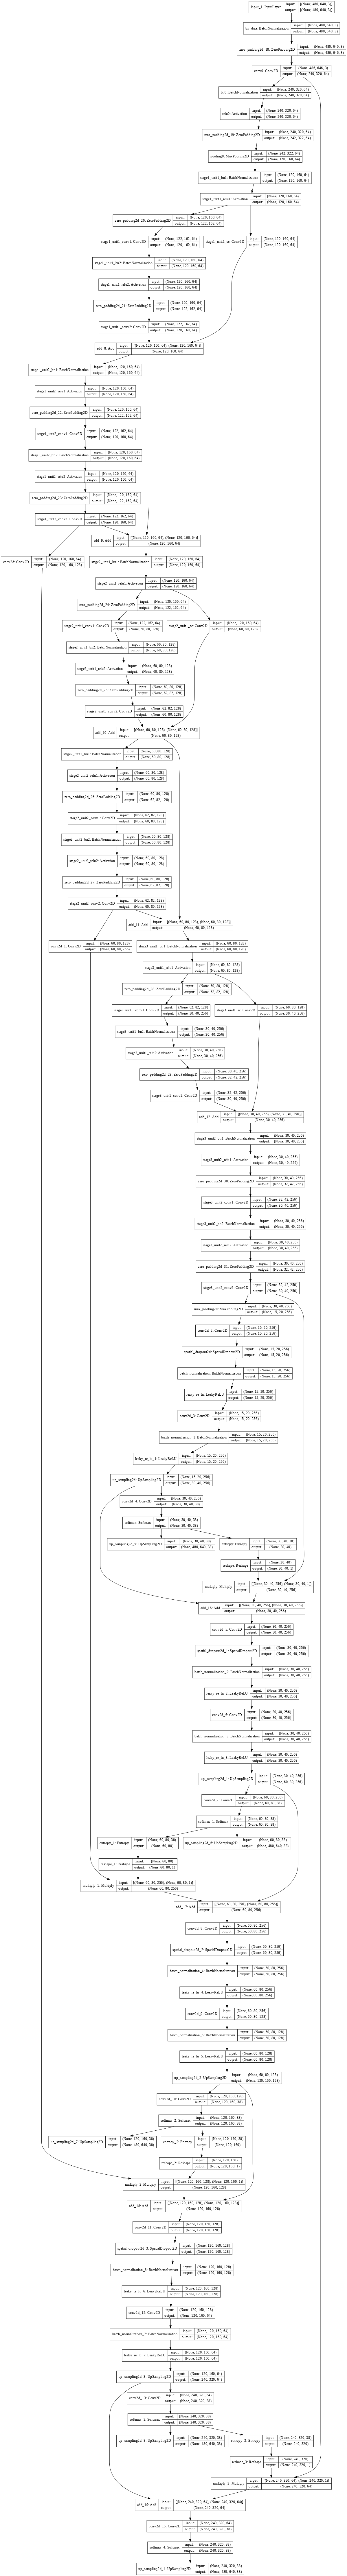

In [22]:
tf.keras.utils.plot_model(model2, show_shapes=True, dpi=64)
# model.summary()

In [23]:
# tf.saved_model.save(model,  '/content/drive/MyDrive/experiment-layers/june-20-skip-layers/mymodel')
# tf.keras.models.load_model('/content/drive/MyDrive/experiment-layers/june-20-skip-layers/mymodel/')


In [24]:
#loss function 
# loss1 = tf.keras.losses.categorical_crossentropy(from_logits=True)
def binary_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred,from_logits=True)
    loss_value = tf.math.reduce_mean(loss,axis=[0])
    return loss_value
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, )
def cross_entropy1(y_true,y_pred):
  return tf.keras.losses.categorical_crossentropy(y_true,y_pred,from_logits=False)
def cross_entropy_loss(y_true,y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(
    y_true, y_pred, axis=-1, name=None)
    return loss

def custom_metrics(y_true,y_pred,smooth=1):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    # y_pred = tf.expand_dims(y_pred,axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_true = y_true[:,:,:,1:38]
    y_pred= y_pred[:,:,:,1:38]
    intersection  = tf.math.reduce_sum((y_true*y_pred),axis = [1,2,3])
    union = (tf.math.reduce_sum(y_true,axis=[1,2,3])+tf.math.reduce_sum(y_pred,axis = [1,2,3])) - intersection
    return tf.math.reduce_mean((intersection+smooth)/(union+smooth),axis=0)
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
# model=tf.keras.models.load_model( '/content/drive/MyDrive/experiment-layers/june-20-skip-layers/dropout/checkpoint/saved_model.pb',custom_objects={
#         'cross_entropy_loss': cross_entropy_loss ,'dice_coef': dice_coef,'custom_metrics':custom_metrics})
model2.compile(loss = [cross_entropy1,cross_entropy1,cross_entropy1,cross_entropy1,cross_entropy1],optimizer=Adam(learning_rate =.0001),metrics=[custom_metrics])

In [25]:
# model.load_weights('/content/drive/MyDrive/experiment-layers/june-19-skip-layers/myfolder/checkpoint')

In [ ]:
epoch=25
t_steps=train_size//4
v_steps=valid_size//4
val_custom_metrics = 0
for i in range(epoch):
  model2.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps)
  loss = model2.evaluate(valid_dataset,steps=v_steps)
  print('val_loss : val_metrics ',loss[0],loss[1])
  if loss[1]>=val_custom_metrics:
    val_custom_metrics = loss[1]
    # tf.saved_model.save(model2,'/content/drive/MyDrive/training-daily/22June/5:30')
    model2.save('/content/drive/MyDrive/training-daily/1July/first',save_format='tf')
  tf.keras.backend.clear_session()
  gc.collect()

 129/1250 [==>...........................] - ETA: 12:02 - loss: 13.9095 - up_sampling2d_5_loss: 1.8409 - up_sampling2d_6_loss: 1.9235 - up_sampling2d_7_loss: 2.1194 - up_sampling2d_8_loss: 3.1190 - up_sampling2d_4_loss: 4.9068 - up_sampling2d_5_custom_metrics: 0.2894 - up_sampling2d_6_custom_metrics: 0.2909 - up_sampling2d_7_custom_metrics: 0.2887 - up_sampling2d_8_custom_metrics: 0.2040 - up_sampling2d_4_custom_metrics: 0.1284

In [ ]:
weight=model2.layers[15].get_weights()
    # weights = layer.get_weights()

In [ ]:
weight

In [ ]:
!nvidia-smi

In [ ]:
dahal=tf.keras.models.load_model('/content/drive/MyDrive/training-daily/july21/kale6/',custom_objects={'cross_entropy_loss':cross_entropy_loss,'custom_metrics':custom_metrics})
dahal.compile(loss = cross_entropy_loss,optimizer=Adam(learning_rate =.001),metrics=[custom_metrics])

In [ ]:
epoch=24
t_steps=train_size//16
v_steps=valid_size//16
val_custom_metrics = 0
for i in range(epoch):
  dahal.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps)
  loss = dahal.evaluate(valid_dataset,steps=v_steps)
  print('val_loss : val_metrics ',loss[0],loss[1])
  if loss[1]>=val_custom_metrics:
    val_custom_metrics = loss[1]
    # tf.saved_model.save(model2,'/content/drive/MyDrive/training-daily/22June/5:30')
    dahal.save('/content/drive/MyDrive/training-daily/22June/kale6.1',save_format='tf')
  tf.keras.backend.clear_session()
  gc.collect()

In [ ]:
def read_image(path):
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float32)
    return x

def read_mask(path):
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = to_categorical(x,num_classes=no_classes+1)
    x = x[:,:,:]
    # x = np.expand_dims(x, axis=-1)
    # x=np.concatenate([x,x],axis=-1)
    x=tf.cast(x,dtype=tf.float32)
    return x
# def custom_metrics(y_true,y_pred,smooth=1):
#     y_pred = tf.math.argmax(y_pred, axis=-1)
#     # y_pred = tf.expand_dims(y_pred,axis=-1)
#     y_pred = tf.one_hot(y_pred,38)
#     y_true = y_true[:,:,:,1:38]
#     y_pred= y_pred[:,:,:,1:38]
#     intersection  = tf.math.reduce_sum((y_true*y_pred),axis = [1,2,3])
#     union = tf.math.reduce_sum(y_true,axis=[1,2,3])+tf.math.reduce_sum(y_pred,axis = [1,2,3]) - intersection 
#     return tf.math.reduce_mean((intersection+smooth)/(union+smooth),axis=0)
def load_data(images,masks):
    length = 1990
    iou=0
    for i,(image,mask) in enumerate(zip(images,masks)):
    
      img = read_image(image)
      mas = read_mask(mask)
      img = np.expand_dims(img,0)
      mas = np.expand_dims(mas,0)
      prediction = dahal.predict(img)
      iou += custom_metrics(mas,prediction)
      print(i,iou)
    return iou/length
no_classes=37
print(len(test_x))
x=load_data(test_x,test_y)
print('*****************************************************************************************************************')
x

In [ ]:
# model2 = main_model2(shape,no_classes)
# model2=tf.keras.models.load_model(filepath2,custom_objects={'cross_entropy_loss':cross_entropy_loss,'dice_coef':dice_coef,'custom_metrics':custom_metrics})

In [ ]:
len(color_list)

In [ ]:
import matplotlib
cmap = matplotlib.colors.ListedColormap(color_list)
cmap1=matplotlib.colors.ListedColormap(color_list)
def plot(image,mask):
    plt.figure(figsize=(14,14))
    # plt.subplot(141)
    # plt.imshow(np.squeeze(prediction)+1,cmap=cmap,vmin=1, vmax=len(color_list))
    # print('here it is')
    # print(np.squeeze(prediction).shape)
    plt.subplot(142)
    plt.imshow(image)
    plt.subplot(143)
    plt.imshow(np.squeeze(mask[:,:,1])+1,cmap=cmap1,vmin=1, vmax=len(color_list))
    print('here it is')
    print(np.squeeze(mask[:,:,2]).shape)
    # plt.subplot(144)
    # plt.imshow(numpy,cmap='gray')
    # print(prediction)

In [ ]:
# import matplotlib
# def plot(image,numpy,prediction):
#     plt.figure(figsize=(14,14))
#     plt.subplot(131)
#     plt.imshow(np.squeeze(prediction),cmap=plt.get_cmap('gray'))
#     plt.subplot(132)
#     plt.imshow(image)
#     plt.subplot(133)
#     plt.imshow(numpy,cmap='gray')

In [ ]:
import cv2 as cv
def prediction(path):
    image = cv.imread(path,cv.IMREAD_COLOR)
    x = cv.resize(image,(640,480),interpolation=cv.INTER_NEAREST)
    x = x/255.0
    x=np.expand_dims(x,0)
    # y = dahal.predict(x)
    # print(y.shape)
    # numpy = np.zeros((y.shape[1],y.shape[2],y.shape[3]))
    # print(numpy.shape)
    # numpy[:,:,:] = y 
    # prediction= numpy.argmax(axis=-1)
    # print(prediction.shape)
    # numpy= tf.one_hot(prediction,38)
    mask = cv.imread(path1,cv.IMREAD_COLOR)
    mask = cv.resize(mask,(640,480),interpolation=cv.INTER_NEAREST)
    plot(image,mask)
    
path = '/content/drive/MyDrive/depth/image/image7963 (1).jpg'
path1='/content/drive/MyDrive/depth/mask/mask7963 (1).png'

prediction1=prediction(path)



5457,*1729,2831* 
2831: bathtub good result

In [ ]:
for i in range(prediction1.shape[2]):
    # for j in range(prediction1.shape[1]):
    #     # if prediction1[i,j]>2:
    (prediction1.shape)
    print(prediction1[])

In [ ]:
import matplotlib
%matplotlib inline
cmap = matplotlib.colors.ListedColormap(color_list)
def p1(path):
    image = cv.imread(path,cv.IMREAD_COLOR)
    x = cv.resize(image,(640,480),interpolation=cv.INTER_NEAREST)
    x = x/255.0
    x=np.expand_dims(x,0)
    print(x.shape)
    return x
def plot2(prediction):
    plt.figure(figsize=(14,14))
    plt.subplot(131)
    plt.imshow(np.squeeze(prediction)+1,cmap=cmap,vmin=1, vmax=len(color_list)) 
import tensorflow as tf

In [ ]:
layer_names=[layer.name for layer in dahal.layers]
layer_names

In [ ]:
layer_names


In [ ]:

def layer_plot(path,layer_name):
  # dahal=tf.keras.models.load_model('/content/drive/MyDrive/training-daily/july21/kale6',custom_objects={'cross_entropy_loss':cross_entropy_loss,'custom_metrics':custom_metrics})
  layer_names=[]
  layer_names=[layer.name for layer in dahal.layers] ### here you can print this output to check the lists of layer names
  features_layer1 = dahal
  p11=features_layer1.predict(p1(path))
  numpy = np.zeros((p11.shape[1],p11.shape[2],p11.shape[3]))
  print(numpy.shape)
  numpy[:,:,:] = p11 
  prediction= numpy.argmax(axis=-1)
  plot2(prediction)
path='/content/drive/MyDrive/depth/image/image1.jpg'
# dahal=tf.keras.models.load_model('/content/drive/MyDrive/training-daily/july21/kale6',custom_objects={'cross_entropy_loss':cross_entropy_loss,'custom_metrics':custom_metrics})
layer_names=[]
layer_names=[layer.name for layer in dahal.layers]
layer=['conv2d_180','conv2d_182','conv2d_187','conv2d_191','conv2d_208','conv2d_192','conv2d_210','conv2d_212']
layer_plot(path,'conv2d_212')
# for i in layer:
#   layer_plot(path,i)

In [ ]:
# def decoder(x):
#   concat_layers = []
#   num_filters = [64,128, 256,512,512,512]
#   num_filters.reverse()
#   size =[32,16,8,4]
#   for i in range(len(num_filters)-1):
#     z = decoder_conv_block(x,num_filters[i],num_filters[i+1])
#     x = UpSampling2D((2,2))(z)
#     if i==0:
#         concat_layers= experiment2(z,num_filters[i+1],size[i])
#     elif i==1:
#         y = experiment2(z,num_filters[i+1],size[i])
#         y = Concatenate()([y,concat_layers])
#     elif (i in [2,3]):
#         y =Concatenate()([y,experiment2(z,num_filters[i+1],size[i])])
#     else:
#         y= Concatenate()([y,x])
#   return y